#### Vít Škvára - Samoorganizace a dolování dat/Self-organization and data mining

# Kernel methods for multiple-instance learning problem

In this protocol, we explore the possibily of using kernel methods, namely smallest enclosing hypersphere, for the task of anomaly detection under the multiple-instance learning paradigm.

## Multiple-instance learning (MIL)

In multiple-instance learning (MIL), the problem of supervised binary classification is made more difficult for the learner due to a number of reasons. Firstly, instead of having a set of instances (feature vectors) labeled as negative or positive, a number of _bags_ of instances is received, where the whole bags are labeled as positive or negative. Every bag consists of a (possibly different) number of instances whose individual labels are not known. The common conception is that a bag is labeled negative if all instances in it are negative, but if even a single instance is positive, then the label of the bag is also positive. Secondly, the ratio of negative to positive instances in a bag can be arbitrarily high. In real-world problems however, this presumption can be violated and positive and negative bags may be generated from entirely different sources. 

Our motivation comes from the area of malware detection in computers connected to a network whose activity is supervised. In such a case, the communication of every computer with the outside world (using a HTTP protocol) goes through a common hub. The observer, for a limited time frame, collects all HTTP requests of the computers in the network. From each request, we substract a number of features (e.g. bytes sent and received, request lenght in ms). A collection of such instances for one computer creates a bag. Additionaly, some computers are known to be infected with malware that communicates with the Internet. Their bags are then labeled as positive and together with bags of some uninfected computers compose a training dataset. Presumably, positive bags should contain a number of positive instances - requests created by the malware. 

## Kernel theory basics

Firstly, we will give a brief introduction to kernel methods and the smallest hypersphere algorithm that will be used to detect outliers or anomalies. A kernel is a mapping
\begin{equation}
    \kappa(x,y) = \langle \phi(x), \phi(y) \rangle
\end{equation}
that encodes data $x,y \in \mathcal{X}$ to feature space $\mathcal{F}$ using a scalar product of an embedding map 
\begin{equation}
    \phi:\mathcal{X} \rightarrow \mathcal{F}.
\end{equation}

The trick of kernel methods is that for a training dataset $X= \lbrace x_1, x_2, \dots, x_m \rbrace$, they are able to use standar linear machine learning techniques on the richer feature space $\mathcal{F}$ without directly computing the potentially computationally demanding mapping $\phi(x_i), i = 1, 2, \dots, m$. Instead, it is sufficient to obtain the kernel matrix $G$, which satistfies 
\begin{equation}
    G_{ij} = \kappa(x_i,x_j) = \langle \phi(x_i), \phi(x_j) \rangle.
\end{equation}
This matrix is symmetric and enables us to use a large number of classical algorithms in the feature space.

The quadratic kernel is one of the simplest. It is defined as 
\begin{equation}
    \kappa(x,y) = \langle x, y \rangle^2
\end{equation}
and its corresponding feature map for $\mathcal{X} = \mathbb{R}^2$ is 
\begin{equation}
    \phi(x) = (x_1^2, x_2^2, \sqrt{2}x_1x_2) 
\end{equation}
embeds the original samples to feature space $\mathcal{F} = \mathbb{R}^3$.



## Experiment 1

We will implement the smallest enclosing sphere algorithm and test it on a simple benchmark problem. 

Firstly, we generate the data and create the kernel.

In [1]:
# here, the required libraries are loaded
using Convex, SCS # for optimization
import Convex.norm2
using ClobberingReload # for deprecation warnings supression
using PyPlot # for plots

We generate a training and a testing dataset in $\mathbb{R}^2$.

In [137]:
srand(123436)
m = 2 # problem dimension
c_data = [1,4] # the data will be offset by this
n_train = 20 # no training samples
X_train = randn(2,n_train) .+ c_data

n_test = 10
X_test = randn(2,n_test) .+ c_data
A = randn(2, n_test)*10 .+ c_data 
X_test = cat(2, X_test, A);

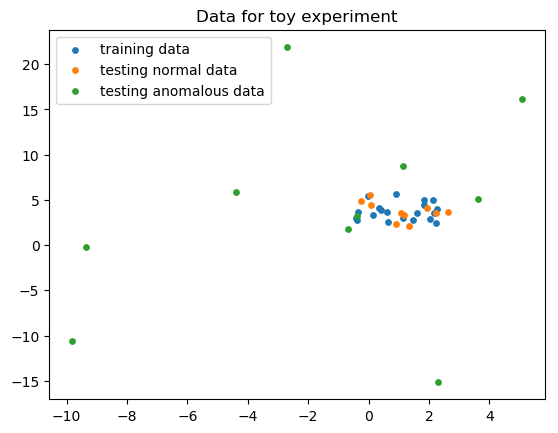

In [138]:
f = figure()
ss = 15
scatter(X_train[1,:], X_train[2,:], s=ss, label = "training data")
scatter(X_test[1,1:n_test], X_test[2,1:n_test], s = ss, 
    label = "testing normal data")
scatter(X_test[1,n_test+1:end], X_test[2,n_test+1:end], s = ss,
    label = "testing anomalous data")
legend()
title("Data for toy experiment");

We will use the quadratic kernel as the generating function has quite a simple form. We will use the form with offset
$$
    \kappa(x,y) = (\langle x, y \rangle + c)^2
$$
which has a feature map
$$
    \varphi(x) = \left( x_1^2, \ldots, x_m^2, \sqrt{2} x_1 x_{2}, \ldots, \sqrt{2} x_1 x_m, \sqrt{2} x_2 x_3, \ldots, \sqrt{2} x_2 x_m, \ldots, \sqrt{2} x_{m-1} x_{m}, \sqrt{2c} x_1, \ldots, \sqrt{2c} x_m, c \right)
$$
We know that the resulting feature space $\mathcal{F}$ has dimension ${{m+2}\choose 2} = 6$ for $m=2$. 

Below, the feature map for a quadratic kernel and a sample space of arbitrary dimension is implemented.

In [132]:
"""
    quadmap(x, c = 0.0)

Is the feature map for quadratic kernel.
"""
function quadmap{T<:Real}(x::AbstractArray{T,1}, c = 0.0)
    m = length(x)
    nq = binomial(m+2,2)
    
    # decrease the resulting dimension if c is zero
    if c == 0
        nq -= (m+1)
    end
    
    # create the resulting array
    res = zeros(nq)
    
    # first the solo quadratic coefficients
    res[1:m] = x.^2
    
    # now the cross-quadratics
    k = 1+m
    for i in 1:m
        for j in 1:(m-i) 
           res[k] = sqrt(2)*x[i]*x[j]
            k += 1
        end
    end
    
    if c != 0
        # now the linear elements
        for i in 1:m
           res[k] = sqrt(2*c)*x[i]
            k += 1
        end

        # now the final constant
        res[end] = c
    end
    
    return res
end

# version for 2D arrays
quadmap{T<:Real}(x::AbstractArray{T,2}, c = 0.0) = 
    mapslices(y -> quadmap(y,c), x, 1)

quadmap (generic function with 4 methods)

Below here, the type representing the quadratic kernel is implemented along with a constructor. The constructor is called with data $X$ and offset $c$ (which has a default value of 0). It computes and stores the kernel matrix and initializes the feature map. Also, an object of type `quadkernel` can be called directly as `quadkernel(x,y)` or `quadkernel(x)` to obtain the value for vectors `x,y`.

Implementation remark: for quadratic kernel and $m<3$, the kernel matrix may not be numerically positive definite, so we add a small number to its diagonal. This has the same effect as adding noise to training samples.

In [133]:
# abstract kernel type
abstract type kernel
end

# quadratic kernel type
struct quadkernel <: kernel
    X # the data matrix
    km # kernel matrix
    ϕ # feature map
    c
end

# constructor
quadkernel(X, c=0) = quadkernel(X, 
    (X'*X .+ c).^2 + eye(size(X,2))*1e-8, # here the noise is added 
    x -> quadmap(x,c), # the feature map is fixed with given c
    c)

# overloaded for direct calling
(qk::quadkernel)(x,y) = (x'*y + qk.c).^(2)
(qk::quadkernel)(x) = qk(x,x)

Now we initialize a new object of type `quadkernel` with the training data. We set $c=0$. Also, we visualize the kernel matrix after initialization.

In [139]:
qk = quadkernel(X_train)
qk.km

20×20 Array{Float64,2}:
 810.247  288.831   428.77    265.641   …  176.319   368.871   333.396 
 288.831  125.452   146.187    86.3035      86.2691  147.769    99.6287
 428.77   146.187   229.023   143.289       86.6388  190.257   182.802 
 265.641   86.3035  143.289    90.5715      49.4719  114.673   117.509 
 196.823   75.2984  102.573    62.5188      48.0713   93.3728   76.322 
 259.031   69.0513  145.051    95.247   …   33.992   100.19    131.31  
 906.599  366.273   466.704   280.704      241.64    444.165   334.894 
 473.155  147.777   257.227   163.91        82.3481  199.753   215.468 
 640.894  221.652   341.315   212.881      132.632   286.723   270.189 
 288.552  101.944   152.987    94.9713      61.8689  130.687   119.595 
 456.056  193.383   232.147   137.919   …  131.199   229.978   161.015 
 310.697  147.952   153.73     88.4783     106.897   168.1      97.5112
 817.517  281.704   435.709   271.974      168.153   364.972   345.647 
 202.486   99.1849   99.4674   56.7781  

## The smallest enclosing hypersphere algorithm

The idea of the algorithm is finding a smallest enclosing hypersphere of the training dataset $X$ in feature space $\mathcal{F}$ that is defined by center $c \in \mathcal{F}$ and radius $r\in \mathbb{R}$. This translates to a nonlinear optimization problem for an unknown weight vector $\alpha \in \mathbb{R}^n$ defined as
$$
    \max_{\alpha} W(\alpha) = \alpha^T \text{diag}(G) - \alpha^T G\alpha
$$
$$
    \text{s.t.} \sum_{i=1}^n \alpha_i = 1, \alpha_i \geq 0, i = 1, \dots, n
$$
where $\text{diag}(G)$ is a vector containing the diagonal elements of $G$.

Let $\alpha^*$ denote the found optimal solution. Then the following holds
$$
    r^* = \sqrt{W(\alpha^{*})}
$$
$$
    c^* = \sum_{i=1}^n \alpha_i^* \phi(x_i)
$$
where $r^*, c^*$ are the radius and center of the smallest sphere that contains all the training data.

For a new sample $x$, the testing function that determines whether the point lies inside or outside the sphere has the following  form
$$
    f(x) = \kappa(x,x) - 2 \sum_{i=1}^n \alpha_i^* \kappa(x_i,x) + D,
$$
$$
    D = \alpha^{*T} G \alpha^* - r^{*2}.
$$
If $f(x) \geq 0$, then the sample lies inside the sphere, otherwise it is outside.

Note that for the computation of the testing function, the exact form  of the feature map $\phi(x)$ is not needed as it is not required here.


The type `kernel_sh` contains the basic building blocks for the smallest enclosing hypersphere algorithm. It contains the kernel (which is again a structure containing kernel matrix, feature map and parameters of the kernel) and parameters of the algorithm: $\alpha^*, r^*, D$ and $c^*$. The constructor is called using a structure of type `kernel`.

In [7]:
# kernelized smallest hypersphere for anomaly detection
mutable struct kernel_sh
    k::kernel # kernel
    α # alpha
    r # hypersphere radius
    D # D constant
    c # hypersphere center
    opt::Bool # was the solution already found?
end

# constructor
kernel_sh(k::kernel) = 
    kernel_sh(k, Array{Float64,1}([]), NaN, NaN, NaN, false)

kernel_sh

The following functions and methods for the `kernel_sh` type implement  $W(\alpha)$, testing function $f(x)$ and the optimization method to find $\alpha^*$. To solve the maximisation problem with linear constraints we use the `Convex` package with `SCS - Splitting Convex Solver`.

In [87]:
W(α,gm) = diag(gm)'*α - sum(gm.*(α*α'))
W(ksh::kernel_sh) = W(ksh.α, ksh.k.km)

function find_sphere!(ksh::kernel_sh, verbose = true)
    # this is the optimization part using Convex and SCS packages
    # setup the variables, objective and constraints
    n = size(ksh.k.km,1)
    α = Variable(n, Positive())
    dkm = diag(ksh.k.km)'
    km = ksh.k.km
    objective = dkm*α - quadform(α, km)
    constraints = [sum(α) == 1.0]
    problem = maximize(objective, constraints) 
    # solve
    no_warnings() do
        solve!(problem, SCSSolver(verbose = verbose))
    end
    # if succesfully solved, extract and round the optimal solution
    if problem.status == :Optimal
        ksh.α = round.(problem.solution.primal[1:n], 3)
        ksh.opt = true
    else
        error("Optimal α not found!")
        nothing
    end
    
    # compute the radius
    ksh.r = sqrt(W(ksh))
    # compute D for the anomaly score function
    ksh.D = ksh.α'*ksh.k.km*ksh.α - ksh.r^2
    # compute the center - but we don't really need this
    # but for the 2D case it is possible
    if !(ksh.k.ϕ == nothing)
        ksh.c = ksh.k.ϕ(ksh.k.X)*ksh.α
    end
    
    return 
end

"""
    anomaly_score(ksh::kernel_sh, x)

This computes the anomaly score/testing function given a kernel 
hypersphere and a sample x.
"""
function anomaly_score(ksh::kernel_sh, x)
    if ksh.opt
        return ksh.k(x) - 2*ksh.α'*ksh.k(ksh.k.X, x) + ksh.D
    else
        warn("The optimum value was not yet found!")
        return NaN
    end
end

"""
    anomaly_score(ksh::kernel_sh, x)

This computes the anomaly score/testing function given a kernel 
hypersphere and a sample x.
"""
function anomaly_score{T<:Real}(ksh::kernel_sh, x::AbstractArray{T,2})
    return [anomaly_score(ksh, x[:,i]) for i in 1:size(x,2)]
end

anomaly_score

Initialize an instance of the `kernel_sh` type using the previously created quadratic kernel and compute the enclosing hypersphere. The output of the splitting conic solver is printed.

In [140]:
# initialize the object
ksh = kernel_sh(qk)
# and find the optimal alpha
find_sphere!(ksh, true)

----------------------------------------------------------------------------
	SCS v1.2.6 - Splitting Conic Solver
	(c) Brendan O'Donoghue, Stanford University, 2012-2016
----------------------------------------------------------------------------
Lin-sys: sparse-direct, nnz in A = 466
eps = 1.00e-04, alpha = 1.80, max_iters = 20000, normalize = 1, scale = 5.00
Variables n = 23, constraints m = 47
Cones:	primal zero / dual free vars: 2
	linear vars: 21
	soc vars: 24, soc blks: 2
Setup time: 1.74e-04s
----------------------------------------------------------------------------
 Iter | pri res | dua res | rel gap | pri obj | dua obj | kap/tau | time (s)
----------------------------------------------------------------------------
     0|      inf       inf      -nan      -inf       inf       inf  3.58e-05 
   100|      inf       inf      -nan      -inf      -inf       inf  6.20e-04 
   200|      inf       inf      -nan      -inf      -inf       inf  1.20e-03 
   300|      inf       inf    

Let us check the results.

In [141]:
println("α opt: $(ksh.α)")
println("r opt: $(ksh.r)")
println("c opt: $(ksh.c)")

α opt: [0.0, 0.0, 0.0, 0.0, 0.0, 0.365, 0.483, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.152, 0.0, 0.0]
r opt: 13.557055848390034
c opt: [2.22603, 18.8904, 3.14808]


We can see that only 3 training samples have non-zero $\alpha$ coefficients. We call them the support vectors. Since the dimensionality of the feature space is 3, this confirms the fact that the smallest enclosing hypersphere can be determined using at most these 3 vectors that lie on the surface of thy hypersphere.

Let us also check how the testing data is score according to the testing function (first 10 testing vectors are normal data).

In [142]:
for i in 1:size(X_test,2)
    as = anomaly_score(ksh, X_test[:,i])
    println("f(x_$(i)): $(as)")
end

f(x_1): -15.798596405804545
f(x_2): -94.06015896438313
f(x_3): 2.2993390073506816
f(x_4): -74.724868544862
f(x_5): -148.34864802953527
f(x_6): -115.8448814241975
f(x_7): -144.18562040439102
f(x_8): -108.7184897762414
f(x_9): -149.42876504873928
f(x_10): 25.848676679520253
f(x_11): 37053.66136323887
f(x_12): 47501.61489681398
f(x_13): 70353.91011231868
f(x_14): 221259.12011273205
f(x_15): 128.29930954177763
f(x_16): 3218.3068817210724
f(x_17): -44.90641471587216
f(x_18): 7437.710289791572
f(x_19): 2168.1429072043125
f(x_20): 385.4852537865876


Now, let us visualize the result in the feature space.

In [143]:
"""
    sphere(r,c,T)

Returns an array containing the coordinates of a sphere 
with radius r and center c discretized at T^2 points.
"""
function sphere(r,c,T)
    θ = linspace(0,pi, T)
    ϕ = linspace(0, 2*pi, T)
    sph = zeros(3,T*T)

    k = 1
    for t1 in 1:T
        for t2 in 1:T
            sph[1,k] = r*sin(θ[t1])*sin(ϕ[t2])
            sph[2,k] = r*sin(θ[t1])*cos(ϕ[t2])
            sph[3,k] = r*cos(θ[t1])
            k+=1
        end
    end
    return sph .+ c
end

sphere

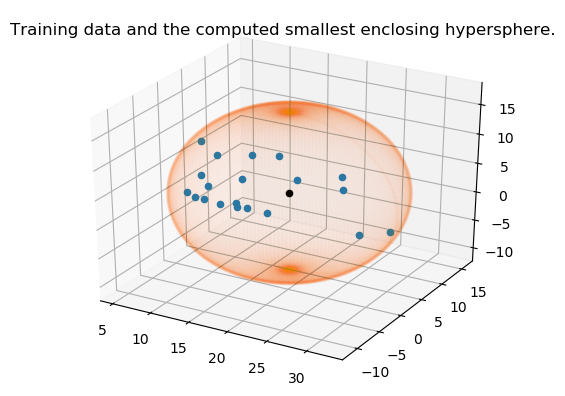

PyObject Text(0.5,0.92,'Training data and the computed smallest enclosing hypersphere.')

In [145]:
# X_train transformed into feature space
phiX_train = ksh.k.ϕ(X_train)
scatter3D(phiX_train[2,:], phiX_train[1,:], phiX_train[3,:],
    depthshade = false)
scatter3D(ksh.c[2,:], ksh.c[1,:], ksh.c[3,:], 
    depthshade = false, c = "black")
ses = sphere(ksh.r, ksh.c, 200)
scatter3D(ses[2,:], ses[1,:], ses[3,:], s= 3, alpha=0.01)
title("Training data and the computed smallest enclosing hypersphere.")

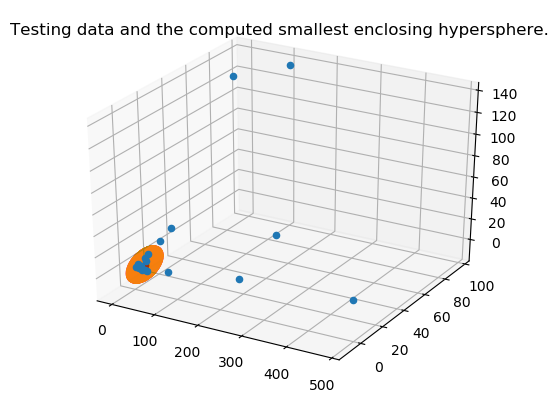

PyObject Text(0.5,0.92,'Testing data and the computed smallest enclosing hypersphere.')

In [144]:
phiX_test = ksh.k.ϕ(X_test)
scatter3D(phiX_test[2,:], phiX_test[1,:], phiX_test[3,:],
    depthshade = false)
scatter3D(ksh.c[2,:], ksh.c[1,:], ksh.c[3,:], 
    depthshade = false, c = "black")
ses = sphere(ksh.r, ksh.c, 200)
scatter3D(ses[2,:], ses[1,:], ses[3,:], s= 3, alpha=0.01)
title("Testing data and the computed smallest enclosing hypersphere.")

# Experiment 2 - MIL data

In the second part of this protocol, we will try to implement and test various kernels for the MIL problem. The implmentation will then be tested on a number of selected benchmark datasets.

## The datasets

We will use the following datasets with different number of features, bags and different average bag size.

In [15]:
using JLD # for data loading
using Distances # for the rbf distance computation
# auxilliary functions for MIL data manipulation
include("/home/vit/Dropbox/vyzkum/cisco/kod/lib/julia/VBMatrixFactorization/examples/mil_util.jl")

plot_statistics

In [16]:
data_path = "./data"
flist = readdir(data_path);
for fname in flist
    fname = split(fname, ".")
    if fname[2] != "jld"
        continue
    else
        fname = fname[1]
    end
    data = load(string(data_path, "/", fname, ".jld"))
    print(fname, ": ", length(unique(data["bagids"])), " bags,", 
        size(data["fMat"])[1], " features, ", 
        round(size(data["fMat"])[2]/length(unique(data["bagids"])), 1), 
        " average bag size\n")
end

BrownCreeper: 548 bags,38 features, 18.7 average bag size
CorelAfrican: 2000 bags,9 features, 4.0 average bag size
CorelBeach: 2000 bags,9 features, 4.0 average bag size
Protein: 193 bags,9 features, 137.9 average bag size
WinterWren: 548 bags,38 features, 18.7 average bag size


## Kernels

We will use a combination of classical kernels (polynomial, RBF, ANOVA) and aggretation methods such as mean, min and max. The aggregation will be done on the space of bags (matrices). It will preserve the dimensionality of the input space but it will aggregate a whole bag (matrix) into a single vector by applying an appropriate function to its columns.

### Polynomial kernel

A general polynomial kernel of order $p$ has the kernel function
$$
    \kappa(x,y) = (\langle x, y \rangle + c)^p.
$$
It is widely used, however large values of $p$ are not usually used as they are prone to overfitting. Also, numerical problems might occur since $\lim_{p \rightarrow \infty} \kappa(x,y) = 0$ for $\langle x, y \rangle < 1$ and $\lim_{p \rightarrow  \infty} \kappa(x,y) = \infty$ for $\langle x, y \rangle > 1$.


We will not implement a feature map for a general polynomial kernel since in the smallest enclosing sphere algorithm it is only needed to obtain the center of the sphere butn ot for the classification. Again, a small number is added to the diagonal of kernel matrix to ameliorate some numerical problems.

In [27]:
struct polykernel <: kernel
    p # polynomial order
    X # the data matrix
    km # kernel matrix
    ϕ # feature map
    c # offset
end

# constructor
polykernel(X, p, c=0, ϵ = 1e-4) = polykernel(p, X, 
    (X'*X .+ c).^p + eye(size(X,2))*ϵ, # here the noise is added 
    nothing, c)

# overloaded for direct calling
(pk::polykernel)(x,y) = (x'*y + pk.c).^(pk.p)
(pk::polykernel)(x) = pk(x,x)

### RBF (Gaussian) kernel

The radial basis function kernel is one of the most widely used. It has the kernel function
$$
    \kappa(x,y) = \exp \left( -\frac {\langle x -y, x-y \rangle}{2\sigma^2} \right).
$$
Here, $\sigma$ is a parameter that controls the width of the kernel. For small values, it is able to fit individual measurements very well and is thus prone to overfittin. Large values of $\sigma$ tend to smooth out and hide information. It is imperative to choose the optimal value well.

The feature space of an RBF kernel has infinite dimensions (as can be shown using a Taylor expansion of the exponential).

In [28]:
struct rbfkernel <: kernel
    σ # kernel width
    X 
    km
    ϕ
end

# constructor
rbfkernel(X, σ, ϵ = 1e-4) = rbfkernel(σ, X, 
    exp.(-pairwise(Euclidean(), X, X).^2/(2*σ^2)) + eye(size(X,2))*ϵ,
    nothing)

# overloaded for direct calling
(rk::rbfkernel)(x,y) = exp.(-pairwise(Euclidean(), x, y).^2/(2*rk.σ^2))
(rk::rbfkernel)(x) = rk(x,x)

In [19]:
# we also need to implement a pairwise method for vectors
import Distances.pairwise
pairwise{T<:Real}(dist::Distances.PreMetric, 
    x::AbstractArray{T,1}, y::AbstractArray{T,1}) = euclidean(x,y)
pairwise{T<:Real}(dist::Distances.PreMetric, 
    x::AbstractArray{T,2}, y::AbstractArray{T,1}) = 
    [euclidean(x[:,i],y) for i in 1:size(x,2)]

pairwise (generic function with 4 methods)

### Aggregating functions

First we create a type that represents a collection of bags. It will be the input value to the aggregating functions.

In [20]:
mutable struct mil
    bags # a list of bags
    labels # a vector of labels
    nbags # number of bags
    M # dimension of input space
end

"""
    mil(data)

From data extracted from a jld file, return the mil type.
"""
function mil(data)
    ids = unique(data["bagids"])
    nbags = length(ids)
    labels = zeros(nbags)
    bags = []
    
    for (i, id) in enumerate(ids)
        push!(bags, data["fMat"][:,data["bagids"].==id])
        labels[i] = data["y"][data["bagids"].==id][1]
    end
    
    return mil(bags, labels, nbags, size(bags[1],1))
end

mil(X, y) = mil(X, y, length(X), size(X,1))

mil

Now we write the individual aggregating functions by overloading the classical methods.

In [21]:
import Base: mean, median, maximum, minimum
mean(m::mil) = cat(2, mean.(m.bags,2)...)
median(m::mil) = cat(2, median.(m.bags,2)...)
maximum(m::mil) = cat(2, maximum.(m.bags,2)...)
minimum(m::mil) = cat(2, minimum.(m.bags,2)...)

minimum (generic function with 17 methods)

Also, whitening of the data is very useful

In [22]:
function whiten!(m::mil)
    m.bags = scaleY.(m.bags)
    return m
end

whiten! (generic function with 1 method)

Let's try to classify one dataset by doing one fold of a 10-fold crossvalidation. Here, normal data is split into 10 bins. We train with 9 and validate on 1. In every fold, the validation bin changes. Whitening of data is very important!

In [114]:
# include the proper libraries
using EvalCurves

function getfold(m::mil, foldi)
    nfolds = 10
    
    # extract normal data
    X_normal = m.bags[m.labels.==0]
    y_normal = m.labels[m.labels.==0]
    n_normal = length(y_normal)
    
    # subsample if there are more than 1000 samples
    if n_normal > 1000
        srand(foldi)
        inds = sample(1:n_normal, 1000, replace=false)
        X_normal = X_normal[inds]
        y_normal = y_normal[inds]
        n_normal = 1000
    end
    
    # fold indices
    foldis  = Int.(round.(linspace(1, n_normal, nfolds+1),0))
    foldis[end] += 1
    mask = repmat([true], n_normal) # mask that represents training data indices
    mask[foldis[foldi]:(foldis[foldi+1]-1)] = false
    
    # training data
    mtrain = mil(X_normal[mask], y_normal[mask])

    # testing data
    mtest = mil(append!(X_normal[.!mask], m.bags[m.labels.==1]),
                cat(1, y_normal[.!mask], m.labels[m.labels.==1]))
    
    return mtrain, mtest
end

function validate(kf, m::mil, agrf, foldi = 1, verbosity = false)
    # get testing and traning data
    mtrain, mtest = getfold(m, foldi)
    
    # construct the kernel
    k = kf(agrf(mtrain))
    
    # now construct a kernel, compute the hypersphereksh = kernel_sh(k)
    ksh = kernel_sh(k)
    find_sphere!(ksh, verbosity)
    
    # get the score on testing dataset
    X_test = agrf(mtest)
    ascore = anomaly_score(ksh, X_test)
    
    # compute true and false positive rates
    tpr, fpr = EvalCurves.roccurve(ascore, mtest.labels)
    auroc = EvalCurves.auc(fpr, tpr)
    
    return auroc, tpr, fpr, ksh
end

function validate(kf, data, aggregf, foldi = 1, whiten =true,
        verbosity = false)
    if whiten
        return validate(kf, whiten!(mil(data)), aggregf, foldi, verbosity)
    else
        return validate(kf, mil(data), aggregf, foldi, verbosity)
    end
end

validate (generic function with 8 methods)

Now try to draw an ROC curve and compute AUROC. Here the ROC is constructed by ordering the samples by their anomaly score. We start in the upper right corner and go by the samples - ideally, all negative samples should be ordered first. When there is a mistake, we decrease the tru positive rate. False negative rate is decreased by every asmple.

In [44]:
idata = 1
data = load(joinpath(data_path, flist[idata]))
agrf = mean

kf(x) = rbfkernel(x, 1e-7)
auroc, tpr, fpr, ksh = validate(kf, data, agrf, 3, false);

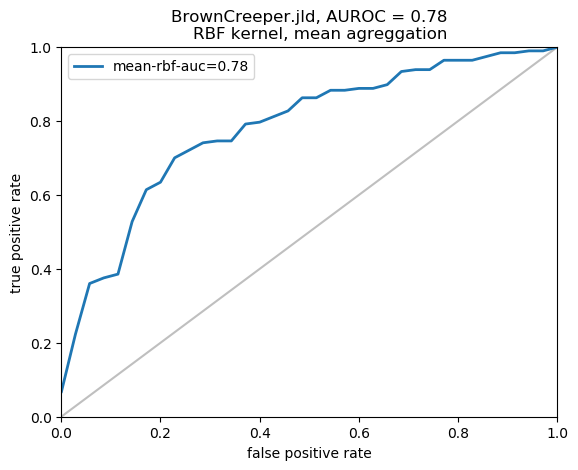

In [45]:
EvalCurves.plotroc([(fpr, tpr, "mean-rbf-auc=$(round(auroc,2))")]...)
title("$(flist[idata]), AUROC = $(round(auroc,2))
    RBF kernel, mean agreggation");

browncreeper

rbf

mean 1e-7

minimum, maximum, median 1e1

Now we are going to try a 10 fold crossvalidation for different datasets and combinations of aggregating functions and kernels.

In [115]:
function crossvalidate(data, k, param, agrf, whiten = true)
    aurocs = zeros(10)
    for i in 1:10
        # create the anonymous kernel function
        kf(x) = k(x, param)
        # get the output
        auroc, _, _, _ = validate(kf, data, agrf, i, whiten, false);
        aurocs[i] = auroc 
    end
    return mean(aurocs), aurocs
end

crossvalidate (generic function with 2 methods)

In [90]:
using DataFrames

df = DataFrame(setup=String[],a=Float64[], b=Float64[], c=Float64[], 
    d=Float64[], e=Float64[])
for (i,name) in enumerate(names(df))
    if i > 1
        rename!(df, name, Symbol(flist[i-1]))
    end
end

settings = [(rbfkernel,1e-7, mean), 
            (rbfkernel,1e0, median),
            (rbfkernel,1e0, minimum),
            (rbfkernel,1e0, maximum)];

First, let's compute the mean AUROC over the 10-fold crossvalidation for the RBF kernel. Note that a different $\sigma$ has to be used for different aggregation functions.

In [91]:
for setting in settings
    row = Array{Any,1}(1+length(flist))
    row[1] = "$(setting[1]), $(setting[2]), $(setting[3])"
    for (i, f) in enumerate(flist)
        data = load(joinpath(data_path, flist[i]))
        mauroc, _ = crossvalidate(data, setting[1], setting[2], 
            setting[3]) 
        row[i+1] = round(mauroc,2)
        println("$(flist[i]) - $(setting[1]), $(setting[2]), $(setting[3]) - done.")
    end
    push!(df, row)
end

BrownCreeper.jld - rbfkernel, 1.0e-7, mean - done.
CorelAfrican.jld - rbfkernel, 1.0e-7, mean - done.
CorelBeach.jld - rbfkernel, 1.0e-7, mean - done.
Protein.jld - rbfkernel, 1.0e-7, mean - done.
WinterWren.jld - rbfkernel, 1.0e-7, mean - done.
BrownCreeper.jld - rbfkernel, 1.0, median - done.
CorelAfrican.jld - rbfkernel, 1.0, median - done.
CorelBeach.jld - rbfkernel, 1.0, median - done.
Protein.jld - rbfkernel, 1.0, median - done.
WinterWren.jld - rbfkernel, 1.0, median - done.
BrownCreeper.jld - rbfkernel, 1.0, minimum - done.
CorelAfrican.jld - rbfkernel, 1.0, minimum - done.
CorelBeach.jld - rbfkernel, 1.0, minimum - done.
Protein.jld - rbfkernel, 1.0, minimum - done.
WinterWren.jld - rbfkernel, 1.0, minimum - done.
BrownCreeper.jld - rbfkernel, 1.0, maximum - done.
CorelAfrican.jld - rbfkernel, 1.0, maximum - done.
CorelBeach.jld - rbfkernel, 1.0, maximum - done.
Protein.jld - rbfkernel, 1.0, maximum - done.
WinterWren.jld - rbfkernel, 1.0, maximum - done.


It seems that the mean aggregation does not work very well. Maximum aggregation works the best. However an AUROC of 0.6 on 3 datasets out of 5 is not very good.

In [92]:
df

,setup,BrownCreeper.jld,CorelAfrican.jld,CorelBeach.jld,Protein.jld,WinterWren.jld
1,"rbfkernel, 1.0e-7, mean",0.69,0.61,0.61,0.63,0.68
2,"rbfkernel, 1.0, median",0.77,0.61,0.62,0.59,0.69
3,"rbfkernel, 1.0, minimum",0.73,0.57,0.58,0.6,0.57
4,"rbfkernel, 1.0, maximum",0.85,0.59,0.64,0.61,0.7


Now, let's do the same for the polynomial kernel of order $p=2$.

In [93]:
settings = [(polykernel,2, mean), 
            (polykernel,2, median),
            (polykernel,2, minimum),
            (polykernel,2, maximum)];

for setting in settings
    row = Array{Any,1}(1+length(flist))
    row[1] = "$(setting[1]), $(setting[2]), $(setting[3])"
    for (i, f) in enumerate(flist)
        data = load(joinpath(data_path, flist[i]))
        mauroc, _ = crossvalidate(data, setting[1], setting[2], 
            setting[3]) 
        row[i+1] = round(mauroc,2)
        println("$(flist[i]) - $(setting[1]), $(setting[2]), $(setting[3]) - done.")
    end
    push!(df, row)
end

BrownCreeper.jld - polykernel, 2, mean - done.
CorelAfrican.jld - polykernel, 2, mean - done.
CorelBeach.jld - polykernel, 2, mean - done.
Protein.jld - polykernel, 2, mean - done.
WinterWren.jld - polykernel, 2, mean - done.
BrownCreeper.jld - polykernel, 2, median - done.
CorelAfrican.jld - polykernel, 2, median - done.
CorelBeach.jld - polykernel, 2, median - done.
Protein.jld - polykernel, 2, median - done.
WinterWren.jld - polykernel, 2, median - done.


LoadError: [91mOptimal α not found![39m

What are the results? We encountered a lot of numerical problems and abandoned the polynomial kernels.

In [94]:
df

,setup,BrownCreeper.jld,CorelAfrican.jld,CorelBeach.jld,Protein.jld,WinterWren.jld
1,"rbfkernel, 1.0e-7, mean",0.69,0.61,0.61,0.63,0.68
2,"rbfkernel, 1.0, median",0.77,0.61,0.62,0.59,0.69
3,"rbfkernel, 1.0, minimum",0.73,0.57,0.58,0.6,0.57
4,"rbfkernel, 1.0, maximum",0.85,0.59,0.64,0.61,0.7
5,"polykernel, 2, mean",1.0,1.0,1.0,1.0,1.0
6,"polykernel, 2, median",0.82,0.56,0.56,0.63,0.75


In [129]:
idata = 1
data = load(joinpath(data_path, flist[idata]))
agrf = mean

kf(x) = polykernel(x, 2, 0, 1e11)
auroc, tpr, fpr, ksh = validate(kf, data, agrf, 4, false);


LoadError: [91mOptimal α not found![39m

In [122]:
foldi = 10
verbosity = false
m = mil(data)

mtrain, mtest = getfold(m, foldi)
    
# construct the kernel
k = kf(agrf(mtrain))

# now construct a kernel, compute the hypersphereksh = kernel_sh(k)
ksh = kernel_sh(k)
find_sphere!(ksh, verbosity)


LoadError: [91mOptimal α not found![39m